In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch
import random


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI project/data_by_all_20230518.csv")

In [5]:
#월별 co2 data 생성
co2 = df[['ID', 'co2(ppm)']]

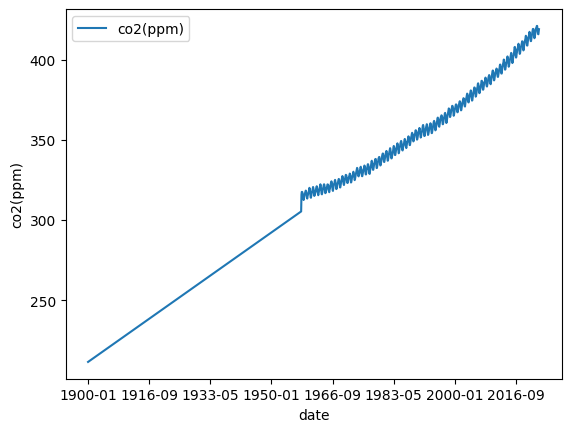

In [6]:
#x축 ID(1900-01 ~ 2022-12), y축이 co2인 그래프 생성
co2.set_index(df['ID']).plot()
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.show()

In [7]:
#ID를 연, 월로 분리하고 int로 형변환해 [연, 월] 형태의 리스트 생성
date_strings = np.array([date.split('-') for date in co2['ID']])
dates = []
for date_string in date_strings:
    date = [int(val) for val in date_string]
    dates.append(date)

In [8]:
#input: 연 월, output(target): co2
X = np.array(dates)
y = co2['co2(ppm)'].values

In [9]:
#input dimesion과 batch size, sequence 길이 설정
seq_length = 12
input_size = X.shape[1]
batch_size = 4

In [10]:
#원하는 sequence만큼 data를 이어줌 (num_data,sequence_length, input_size)형태)
def data_to_seq(data, input_size, seq_length):
    data_seq = np.array([])
    for i in range(0, data.shape[0] - (seq_length - 1)):
        data_seq = np.append(data_seq, data[i:i + seq_length])
    return data_seq.reshape(-1, seq_length, input_size)

In [11]:
#Minmax scaler를 통해 normalize
#나올 수 있는 모든 값들이 random하게 선택되었다는 가정하에 전체 데이터셋에 대하여 scaling 진행
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [12]:
#input data를 sequential하게 이어줌
X_seq = data_to_seq(data = X_scaled, input_size = input_size,seq_length = seq_length)

In [17]:
#train, test set 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq, y[seq_length - 1:], test_size = 0.2, random_state = 0)

In [19]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [20]:
train = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train, batch_size = batch_size, shuffle=True)

test = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test, batch_size = batch_size, shuffle=False)

In [21]:
#LSTM
class LSTM_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.lstm(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)

In [22]:
#RNN
class RNN_model(torch.nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_layers):
        super(RNN_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn_layer = torch.nn.RNN(
            input_size = self.input_size,
            hidden_size = self.hidden_size, 
            num_layers = self.num_layers, 
            batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, output_size) 
    def forward(self,x):
        x = x.to(device)
        y, hidden = self.rnn_layer(x)
        y = y[:,-1, :]
        y = self.fc(y)
        return y.view(-1)

In [23]:
#GRU
class GRU_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.gru(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)


In [24]:
def train(model, dataloader, loss_fn, optim, epochs, device):
    model.train()
    num_batch = len(dataloader)
    for epoch in range(1, epochs + 1):
        train_loss = 0
        for x, y_true in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            train_loss += loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
        train_loss /= num_batch
        if epoch % 20 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.8f}')
    return train_loss

In [25]:
def validation(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0
    num_batch = len(dataloader)
    with torch.no_grad():
        for x, y_true  in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            val_loss += loss.item()
    val_loss /= num_batch
    return val_loss

In [26]:
#learning late, hidden size, layer 수, output dimesion, epoch, device 설정
lr = 0.001
hidden_size = 10
num_layers = 1
output_size = 1
epochs = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
#RNN 모델
model_1 = RNN_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_1 = torch.nn.MSELoss().to(device)
optim_1 = torch.optim.Adam(params=model_1.parameters(), lr = lr )


In [28]:
#LSTM 모델
model_2 = LSTM_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_2 = torch.nn.MSELoss().to(device)
optim_2 = torch.optim.Adam(params=model_2.parameters(), lr = lr )

In [29]:
#GRU 모델
model_3 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_3 = torch.nn.MSELoss().to(device)
optim_3 = torch.optim.Adam(params=model_3.parameters(), lr = lr )

In [30]:
#RNN 모델 training
train(model = model_1, dataloader = train_dataloader, loss_fn = loss_func_1, optim = optim_1, epochs = epochs, device = device)

Epoch: 20, Train Loss: 65083.79468190
Epoch: 40, Train Loss: 38445.78784930
Epoch: 60, Train Loss: 19630.20887689
Epoch: 80, Train Loss: 8342.09172678
Epoch: 100, Train Loss: 2827.96926548
Epoch: 120, Train Loss: 694.98595991
Epoch: 140, Train Loss: 151.40026888
Epoch: 160, Train Loss: 29.70528210
Epoch: 180, Train Loss: 8.85537295
Epoch: 200, Train Loss: 6.17372785
Epoch: 220, Train Loss: 5.58507570
Epoch: 240, Train Loss: 5.19424762
Epoch: 260, Train Loss: 4.74143916
Epoch: 280, Train Loss: 4.46501053
Epoch: 300, Train Loss: 4.10054592


4.100545921753901

In [31]:
#LSTM 모델 training
train(model = model_2, dataloader = train_dataloader, loss_fn = loss_func_2, optim = optim_2, epochs = epochs, device = device)

Epoch: 20, Train Loss: 64520.61056821
Epoch: 40, Train Loss: 38031.53238988
Epoch: 60, Train Loss: 19355.43019411
Epoch: 80, Train Loss: 8198.41162172
Epoch: 100, Train Loss: 2701.49094383
Epoch: 120, Train Loss: 657.38575581
Epoch: 140, Train Loss: 116.56092542
Epoch: 160, Train Loss: 16.70272865
Epoch: 180, Train Loss: 4.69374018
Epoch: 200, Train Loss: 3.38859425
Epoch: 220, Train Loss: 3.61210887
Epoch: 240, Train Loss: 2.94842156
Epoch: 260, Train Loss: 2.71564258
Epoch: 280, Train Loss: 2.46753025
Epoch: 300, Train Loss: 2.22499512


2.2249951244621147

In [32]:
#GRU 모델 training
train(model = model_3, dataloader = train_dataloader, loss_fn = loss_func_3, optim = optim_3, epochs = epochs, device = device)

Epoch: 20, Train Loss: 65143.15054394
Epoch: 40, Train Loss: 38498.24579711
Epoch: 60, Train Loss: 19659.78107502
Epoch: 80, Train Loss: 8357.62720565
Epoch: 100, Train Loss: 2821.77075642
Epoch: 120, Train Loss: 690.36151021
Epoch: 140, Train Loss: 125.60115850
Epoch: 160, Train Loss: 16.03103957
Epoch: 180, Train Loss: 3.37754814
Epoch: 200, Train Loss: 2.31850585
Epoch: 220, Train Loss: 1.93381261
Epoch: 240, Train Loss: 1.67783499
Epoch: 260, Train Loss: 2.34428597
Epoch: 280, Train Loss: 1.09008746
Epoch: 300, Train Loss: 1.02331523


1.0233152268181076

In [33]:
#RNN 모델 test loss
validation(model_1, test_dataloader, loss_func_1, device)

2.8569431457970595

In [34]:
#LSTM 모델 test loss
validation(model_2, test_dataloader, loss_func_2, device)

1.220159254867483

In [35]:
#GRU 모델 test loss
validation(model_3, test_dataloader, loss_func_3, device)

0.7495628089417476

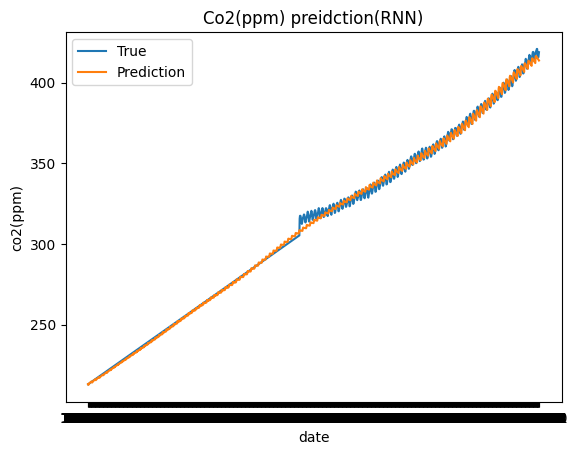

In [36]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 RNN모델 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length - 1:],co2['co2(ppm)'][seq_length - 1:], label = 'True')
plt.plot(co2.ID.values[seq_length - 1:], model_1(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(RNN)')
plt.legend()
plt.show()

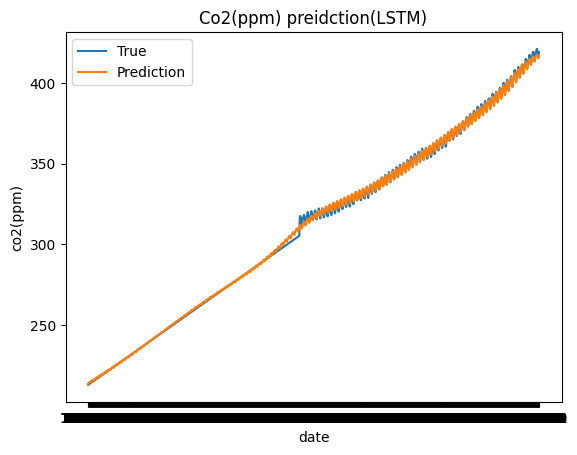

In [37]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 LSTM모델 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length - 1:],co2['co2(ppm)'][seq_length - 1:], label = 'True')
plt.plot(co2.ID.values[seq_length - 1:], model_2(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(LSTM)')
plt.legend()
plt.show()

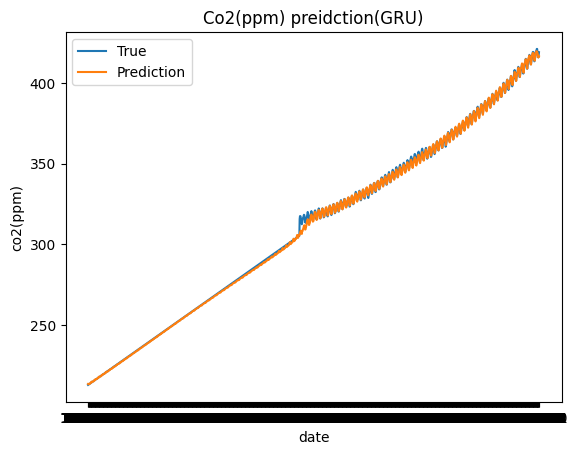

In [38]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 GRU모델 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length - 1:],co2['co2(ppm)'][seq_length - 1:], label = 'True')
plt.plot(co2.ID.values[seq_length - 1:], model_3(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(GRU)')
plt.legend()
plt.show()

In [39]:
#RNN, LSTM, GRU을 ensemble한 model
class EnsembleModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(EnsembleModel, self).__init__()
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.rnn_model = RNN_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x= x.to(device)
        output_gru = self.gru_model(x)
        output_rnn = self.rnn_model(x)
        output_lstm = self.lstm_model(x)

        output = torch.mean(torch.Floattensor(output_rnn,output_gru, output_lstm))

        return output

In [40]:
#LSTM, GRU을 ensemble한 model
class EnsembleModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(EnsembleModel, self).__init__()
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x= x.to(device)
        output_gru = self.gru_model(x)
        output_lstm = self.lstm_model(x)

        output = torch.mean(torch.Floattensor(output_gru, output_lstm))

        return output

In [41]:
#Ensemble(RNN, LSTM, GRU)
model_4 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_4 = torch.nn.MSELoss().to(device)
optim_4 = torch.optim.Adam(params=model_4.parameters(), lr = lr )

In [42]:
#Ensemble(RNN, LSTM, GRU) 모델 training
train(model = model_4, dataloader = train_dataloader, loss_fn = loss_func_4, optim = optim_4, epochs = epochs, device = device)

Epoch: 20, Train Loss: 64804.74643371
Epoch: 40, Train Loss: 38239.53429301
Epoch: 60, Train Loss: 19493.97091977
Epoch: 80, Train Loss: 8274.99241227
Epoch: 100, Train Loss: 2793.18085295
Epoch: 120, Train Loss: 683.77400960
Epoch: 140, Train Loss: 122.78955657
Epoch: 160, Train Loss: 17.00461906
Epoch: 180, Train Loss: 4.21385484
Epoch: 200, Train Loss: 2.58470730
Epoch: 220, Train Loss: 2.33656315
Epoch: 240, Train Loss: 2.25409421
Epoch: 260, Train Loss: 2.19299387
Epoch: 280, Train Loss: 2.20169092
Epoch: 300, Train Loss: 1.96489930


1.9648993028766466

In [43]:
#Ensemble(RNN, LSTM, GRU) 모델 test loss
validation(model_4, test_dataloader, loss_func_4, device)

1.1209757360503882

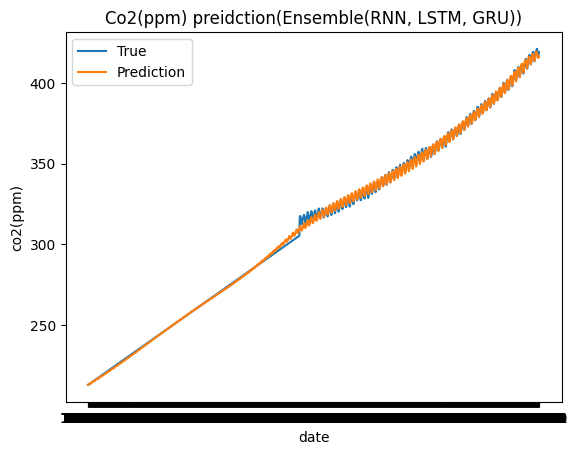

In [44]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 Ensemble모델(RNN, LSTM, GRU) 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length - 1:],co2['co2(ppm)'][seq_length - 1:], label = 'True')
plt.plot(co2.ID.values[seq_length - 1:], model_4(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(Ensemble(RNN, LSTM, GRU))')
plt.legend()
plt.show()

In [45]:
#Ensemble(LSTM, GRU)
model_5 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_5 = torch.nn.MSELoss().to(device)
optim_5 = torch.optim.Adam(params=model_5.parameters(), lr = lr )

In [46]:
#Ensemble(LSTM, GRU) 모델 training
train(model = model_5, dataloader = train_dataloader, loss_fn = loss_func_5, optim = optim_5, epochs = epochs, device = device)

Epoch: 20, Train Loss: 64796.62310687
Epoch: 40, Train Loss: 38233.71330725
Epoch: 60, Train Loss: 19487.01026640
Epoch: 80, Train Loss: 8267.20123333
Epoch: 100, Train Loss: 2773.12615922
Epoch: 120, Train Loss: 674.41948415
Epoch: 140, Train Loss: 118.70778839
Epoch: 160, Train Loss: 15.50480918
Epoch: 180, Train Loss: 7.35203833
Epoch: 200, Train Loss: 2.41641992
Epoch: 220, Train Loss: 2.28723098
Epoch: 240, Train Loss: 2.22144505
Epoch: 260, Train Loss: 2.07001781
Epoch: 280, Train Loss: 1.89131512
Epoch: 300, Train Loss: 1.65158866


1.6515886597081053

In [47]:
#Ensemble(LSTM, GRU) 모델 test loss
validation(model_5, test_dataloader, loss_func_5, device)

0.9314322478792353

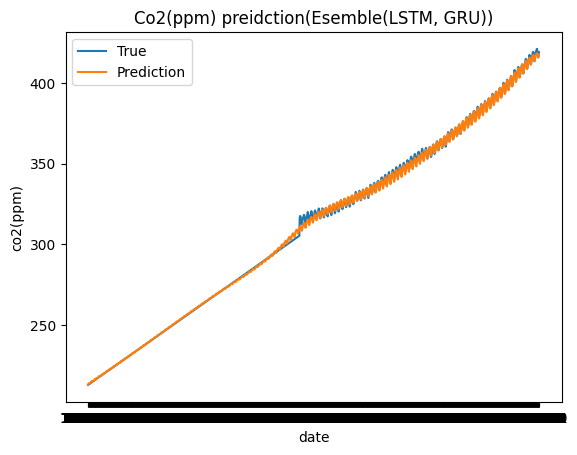

In [48]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 Ensemble모델(LSTM, GRU) 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length - 1:],co2['co2(ppm)'][seq_length - 1:], label = 'True')
plt.plot(co2.ID.values[seq_length - 1:], model_5(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(Esemble(LSTM, GRU))')
plt.legend()
plt.show()